In [7]:
import numpy as np 
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
import os
import sys
import importlib

In [2]:
# Define macro information about where to find the directories/files for all of the data
path_to_ssd: str = '/Volumes/EXTERNAL1'         
experiment_name: str = 'hour_5hz_0NDF'
frequency: float = 5
NDF: int = 0 

In [3]:
# Define paths to individual sensor readings
world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world')
pupil_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_pupil')
sunglasses_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_sunglasses.txt')
MS_readings_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_MS_readings')

assert(all([os.path.exists(path)] for path in [world_cam_dir, pupil_cam_dir, MS_readings_dir, sunglasses_file]))

Analyzing chunk 1/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.7655813722976461
Amplitude: 0.15109895160807965


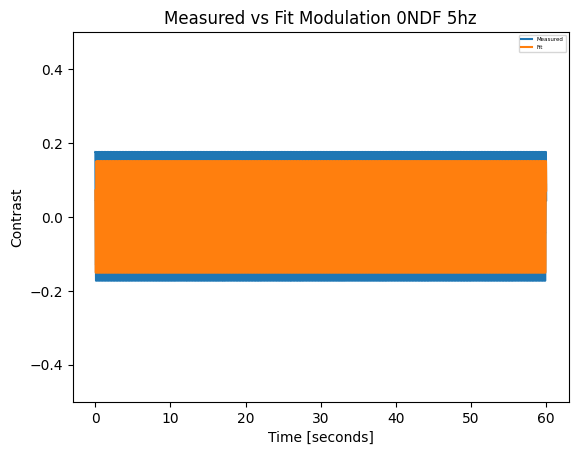

Analyzing chunk 2/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.017074797790825196
Amplitude: 0.02249191067086757


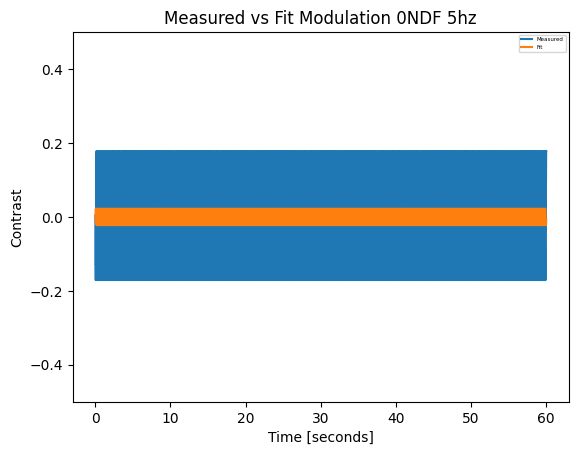

Analyzing chunk 3/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.03501161837792297
Amplitude: 0.03213935329736843


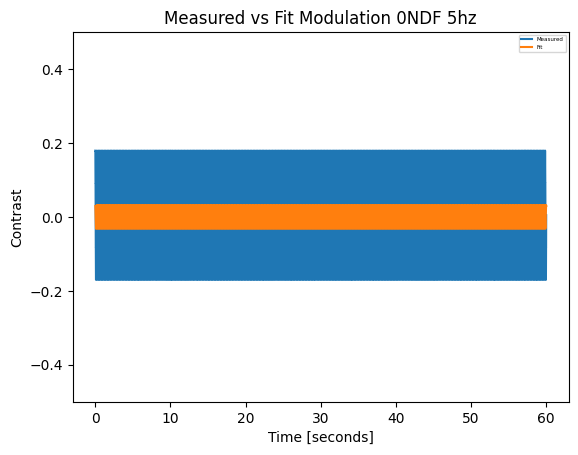

Analyzing chunk 4/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.014225570395649527
Amplitude: 0.020425788128747693


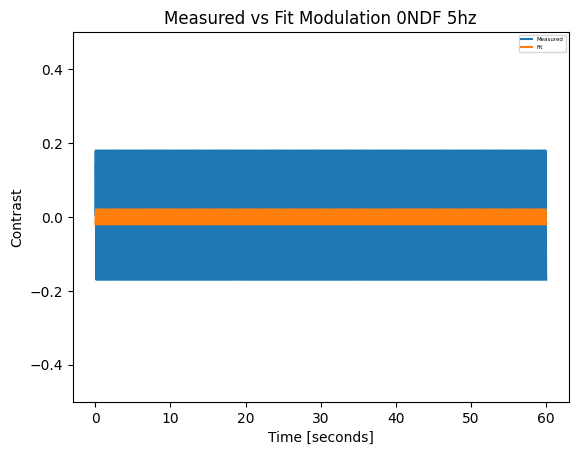

Analyzing chunk 5/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.018452552480586353
Amplitude: 0.023246144105350003


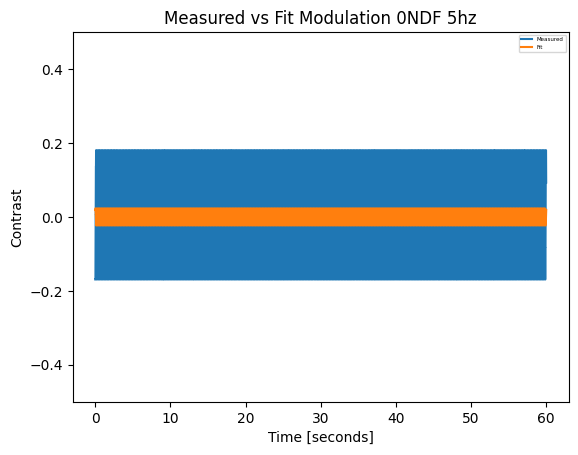

Analyzing chunk 6/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.006365374094151114
Amplitude: 0.013630263427426032


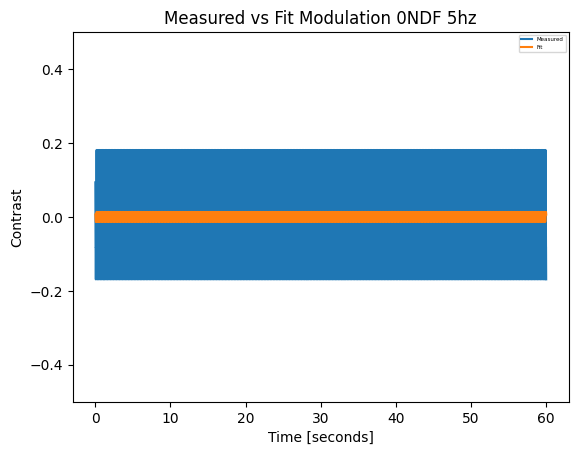

Analyzing chunk 7/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.007173844975037802
Amplitude: 0.014455554856303239


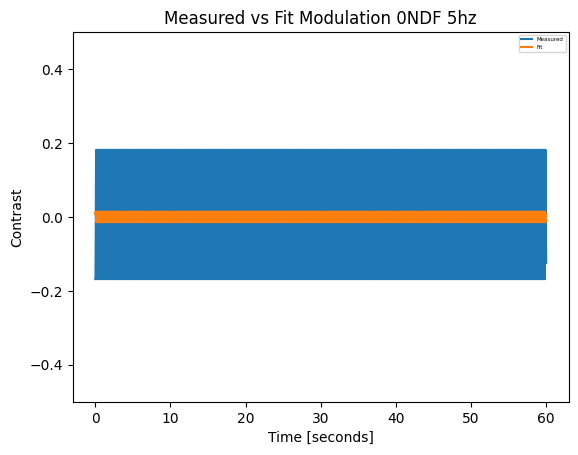

Analyzing chunk 8/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.025618292243733794
Amplitude: 0.027317523858177862


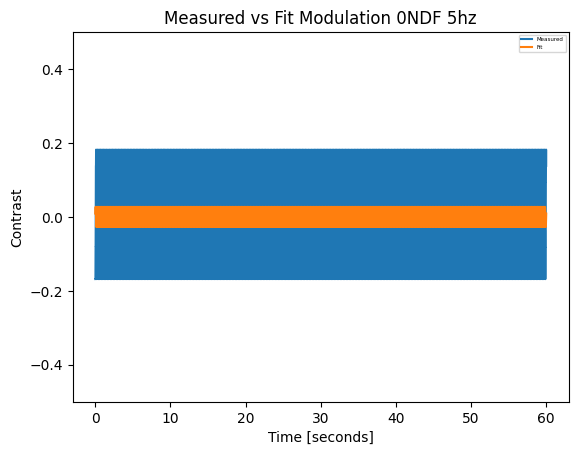

Analyzing chunk 9/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.017695063909070757
Amplitude: 0.02265063686318827


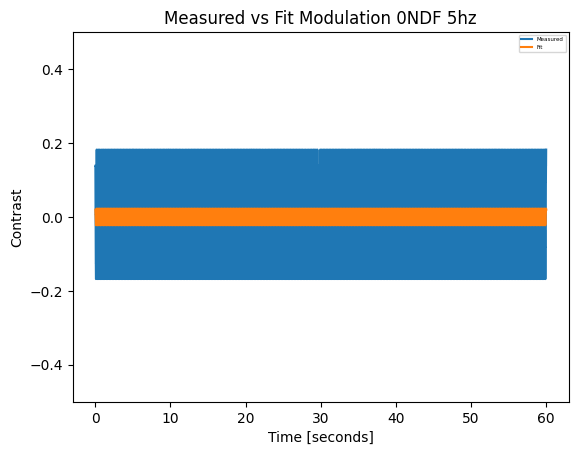

Analyzing chunk 10/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.009343927016489178
Amplitude: 0.01645652241096934


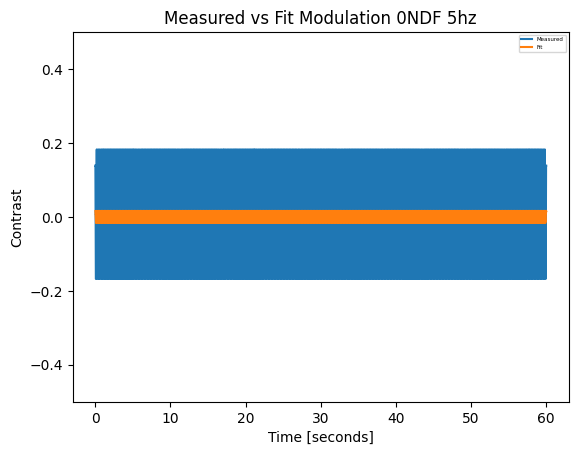

Analyzing chunk 11/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.026513647976124887
Amplitude: 0.02774881886982041


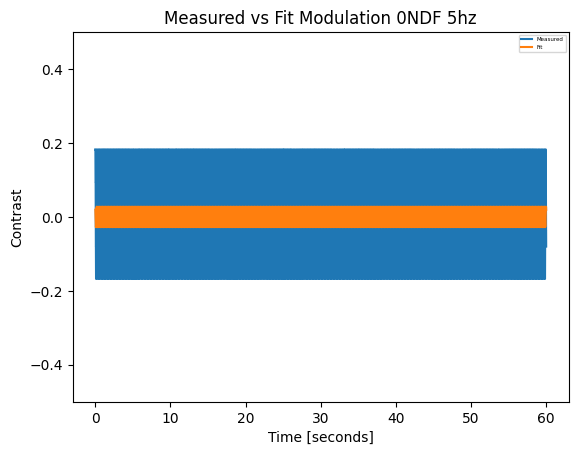

Analyzing chunk 12/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.004849977084535372
Amplitude: 0.011861119790438608


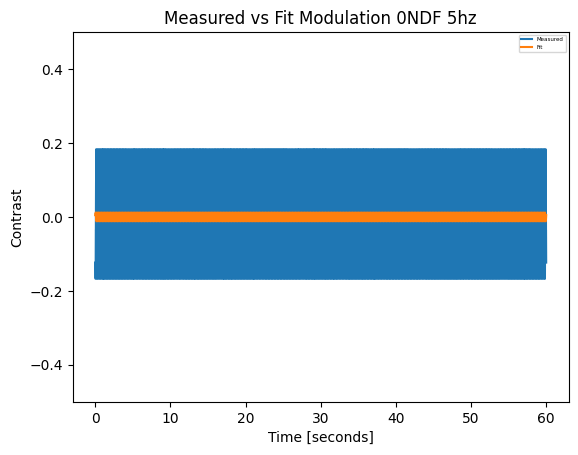

Analyzing chunk 13/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.016429503335576263
Amplitude: 0.021803749286055517


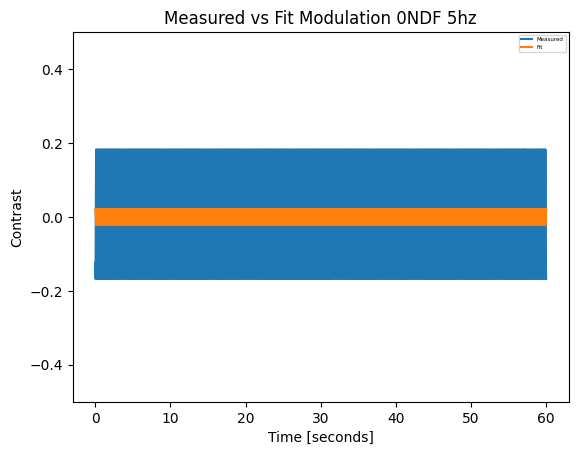

Analyzing chunk 14/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.019829018220918582
Amplitude: 0.023947556623740558


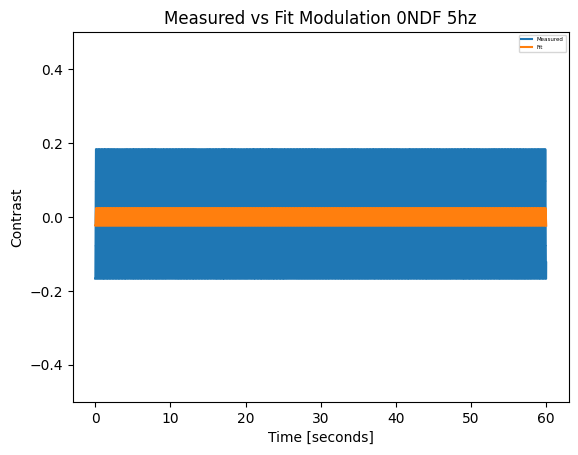

Analyzing chunk 15/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.012938800180151517
Amplitude: 0.019362811998350805


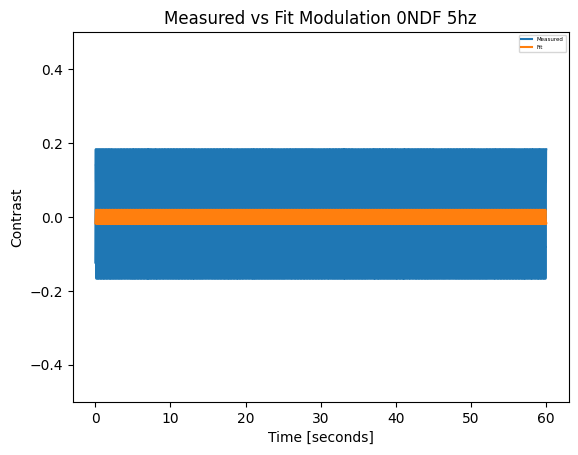

Analyzing chunk 16/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0684981949357741
Amplitude: 0.04450942481253915


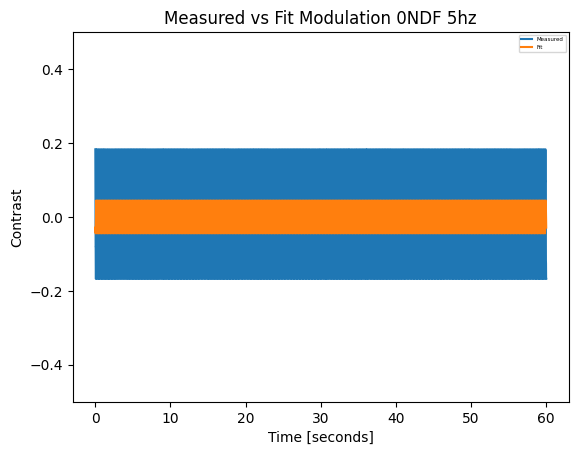

Analyzing chunk 17/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.006494902335440977
Amplitude: 0.013694796858235462


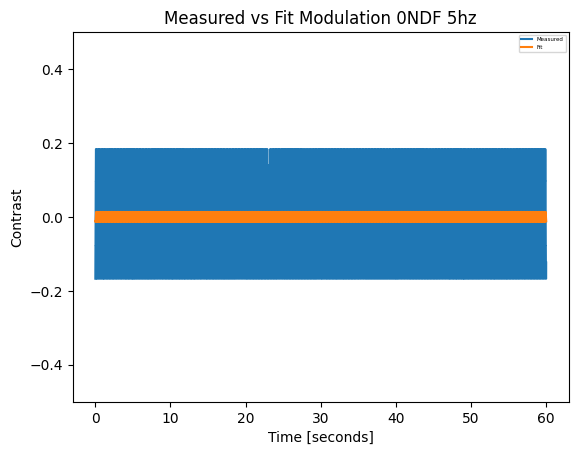

Analyzing chunk 18/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.04605904513721763
Amplitude: 0.03646970256138252


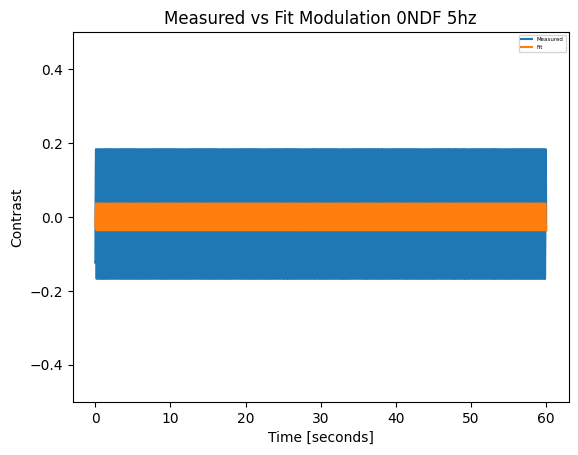

Analyzing chunk 19/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.054069059794304986
Amplitude: 0.03957020824502347


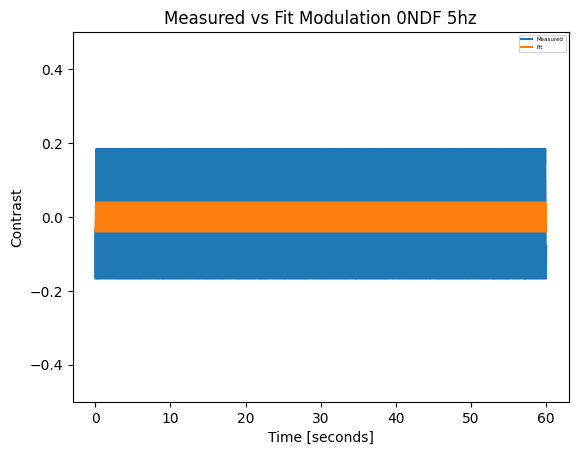

Analyzing chunk 20/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.003377176087673377
Amplitude: 0.009882086218752521


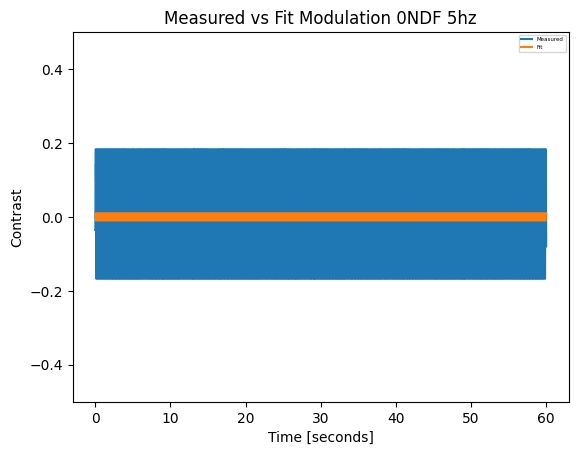

Analyzing chunk 21/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.007414792271831636
Amplitude: 0.014627584052622567


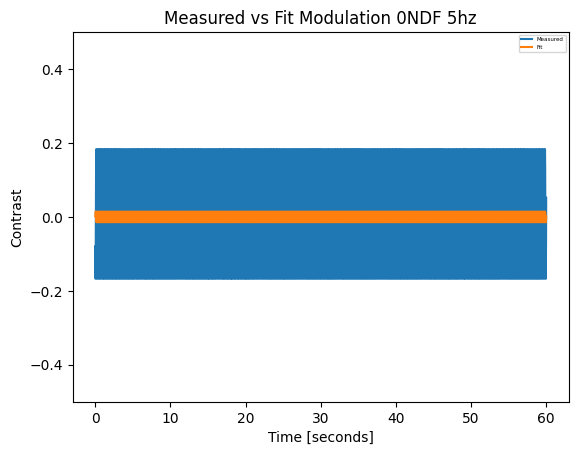

Analyzing chunk 22/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.012196359270557755
Amplitude: 0.018770591775399855


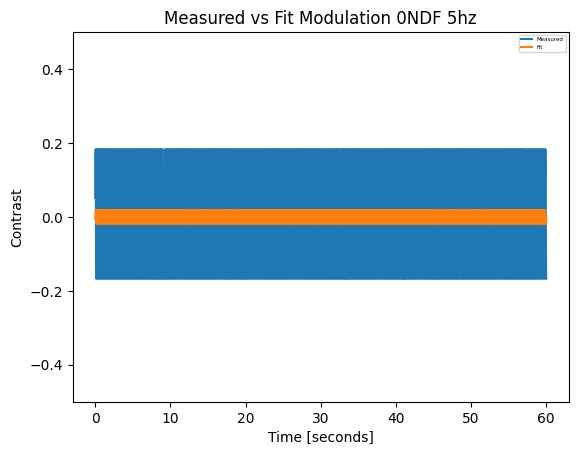

Analyzing chunk 23/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0007195033431430444
Amplitude: 0.004561146384450542


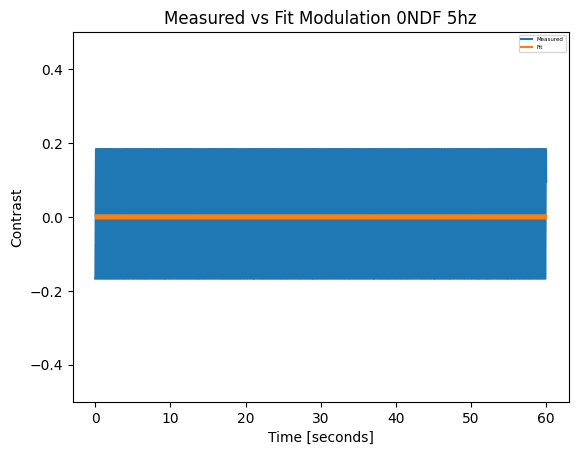

Analyzing chunk 24/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.009376191746914578
Amplitude: 0.016453971279325318


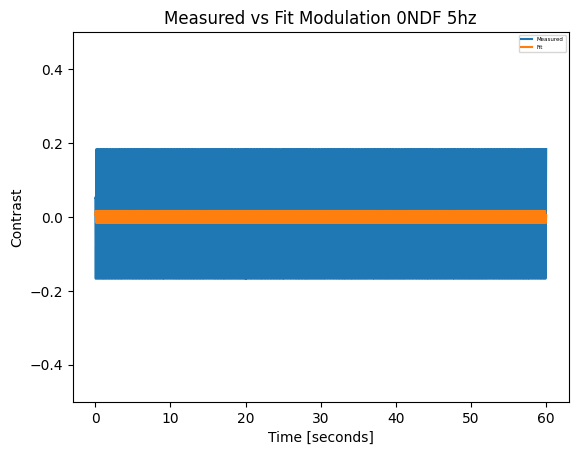

Analyzing chunk 25/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.005866035329042408
Amplitude: 0.012997504339223745


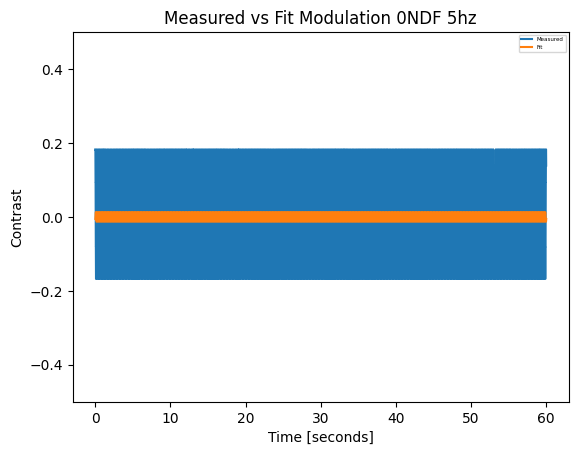

Analyzing chunk 26/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.03303102900710567
Amplitude: 0.030911395546976726


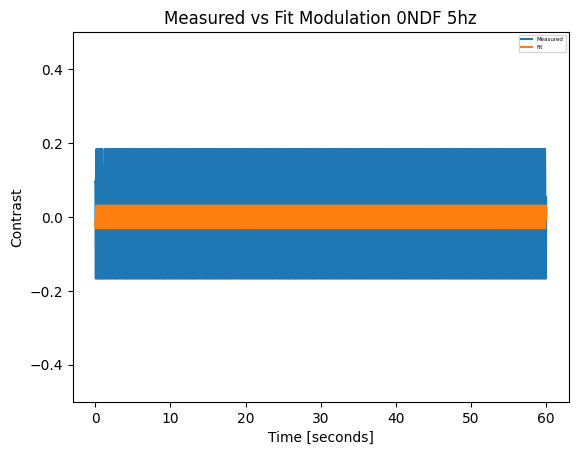

Analyzing chunk 27/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.009159123630260666
Amplitude: 0.016283334653158083


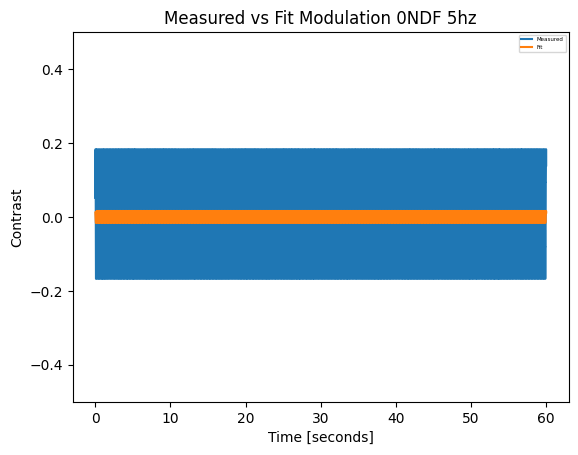

Analyzing chunk 28/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.03616431454220322
Amplitude: 0.03230908614896856


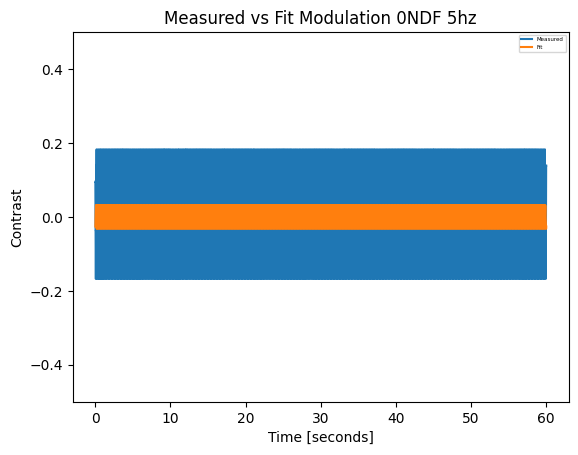

Analyzing chunk 29/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.03853108652941136
Amplitude: 0.033386551567169666


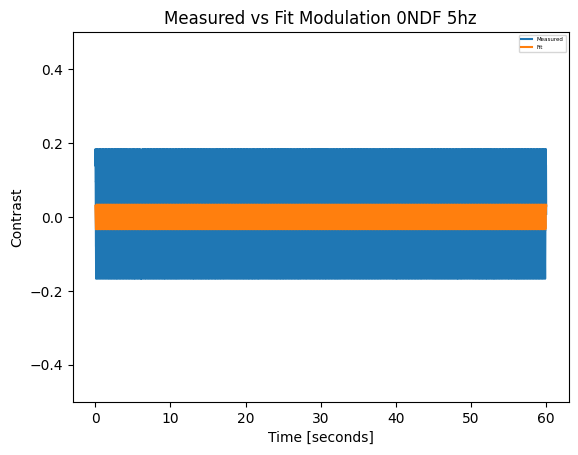

Analyzing chunk 30/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.01805404135687248
Amplitude: 0.022842227059691016


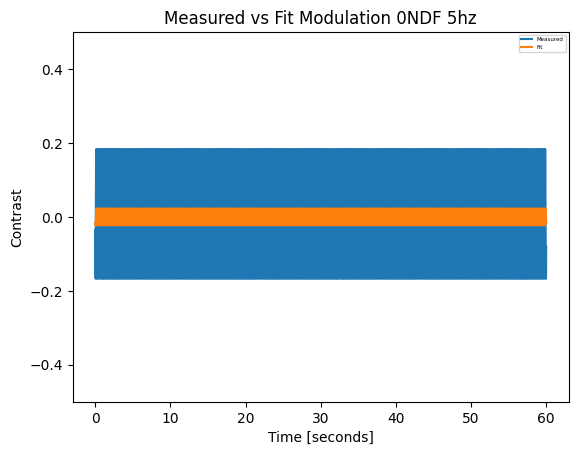

Analyzing chunk 31/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.038058555810855974
Amplitude: 0.03318774797895318


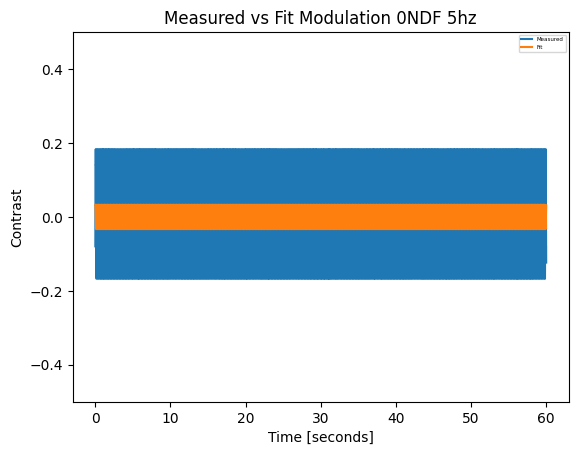

Analyzing chunk 32/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.005525468521787034
Amplitude: 0.012641104690007812


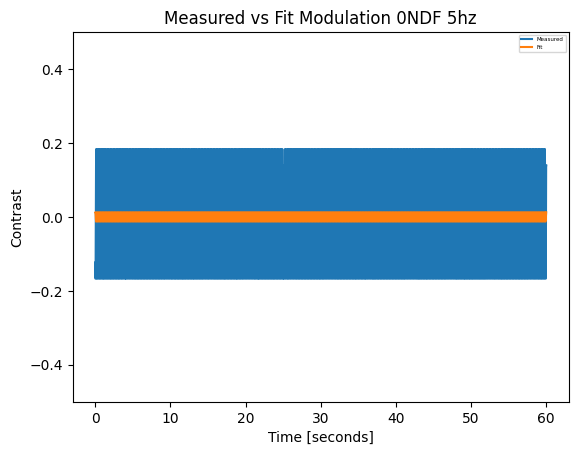

Analyzing chunk 33/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.008454603150621711
Amplitude: 0.015630716788142027


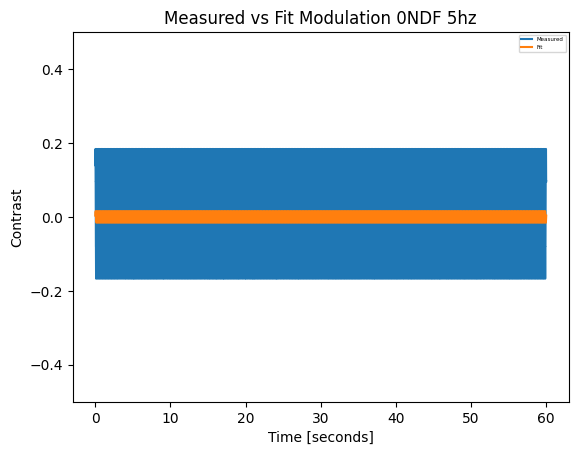

Analyzing chunk 34/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.04241419807308952
Amplitude: 0.03500733360113041


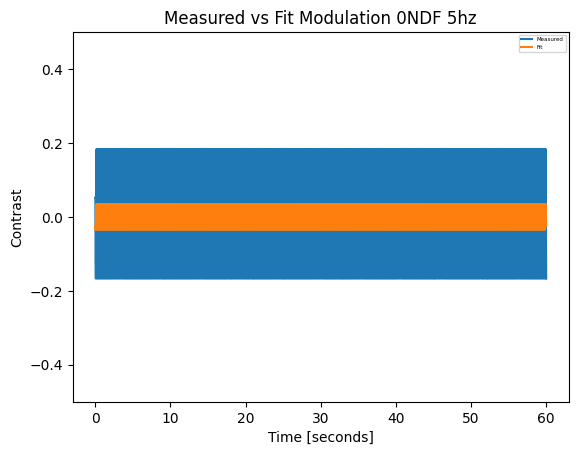

Analyzing chunk 35/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.015307223222809644
Amplitude: 0.02104177435177746


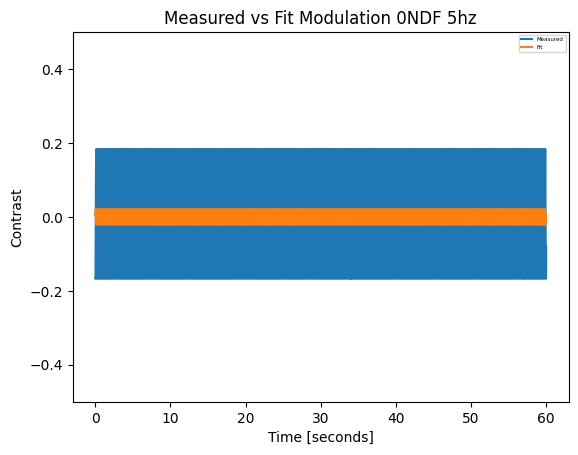

Analyzing chunk 36/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.019962451373521203
Amplitude: 0.024016501734049078


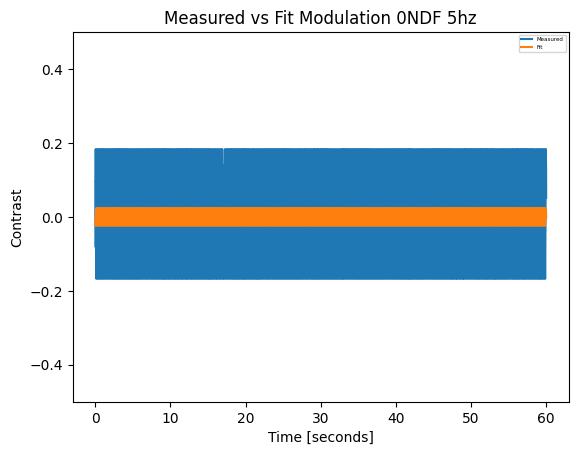

Analyzing chunk 37/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0028011046298290184
Amplitude: 0.009000547032080522


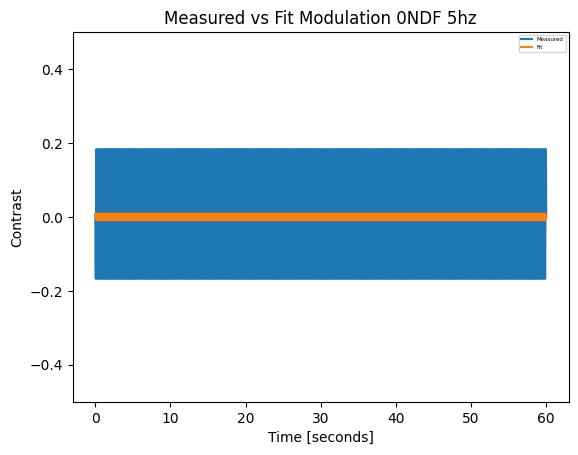

Analyzing chunk 38/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.01214000626661895
Amplitude: 0.01873679915808845


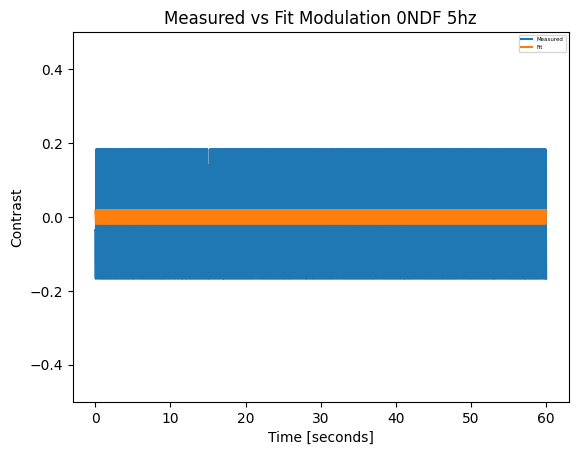

Analyzing chunk 39/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.05156569600893497
Amplitude: 0.03863674729652282


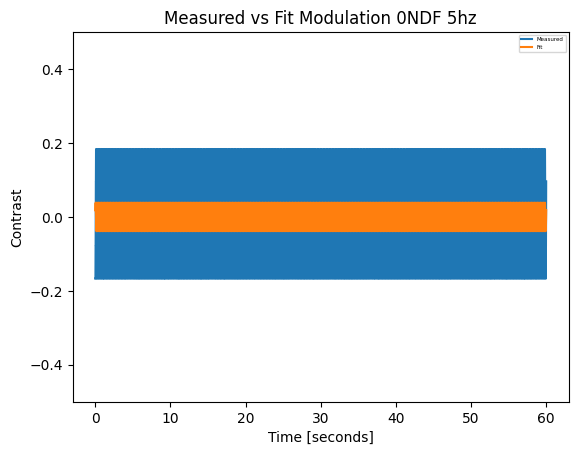

Analyzing chunk 40/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.009458108226545634
Amplitude: 0.01652078506090833


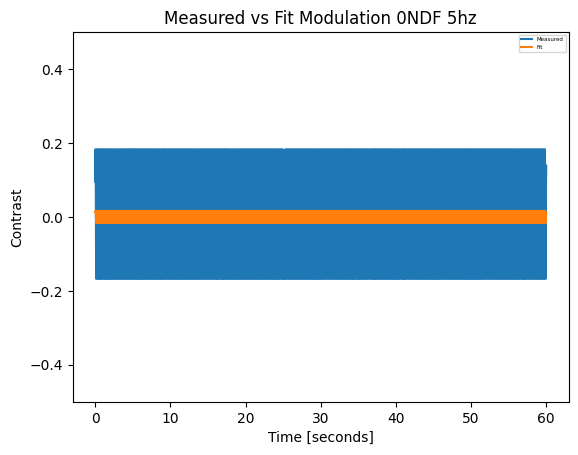

Analyzing chunk 41/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.026683030355798845
Amplitude: 0.02777660312760927


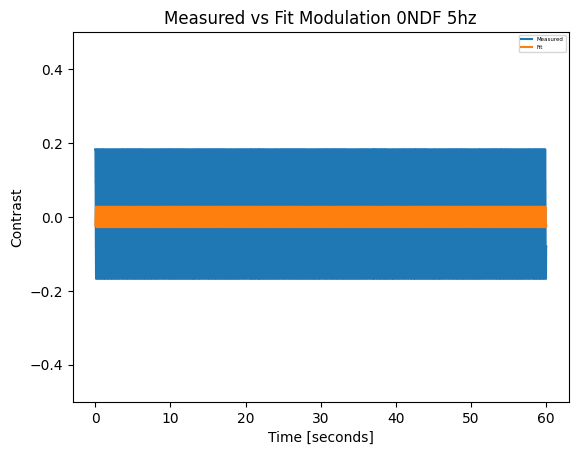

Analyzing chunk 42/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.006627116198285798
Amplitude: 0.013844713397882203


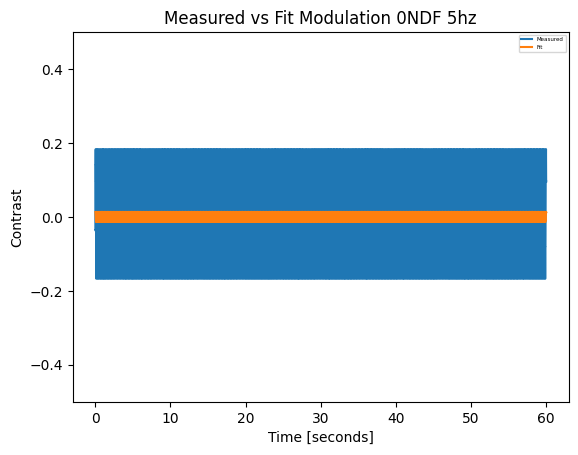

Analyzing chunk 43/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.01600570281135693
Amplitude: 0.02149173580503489


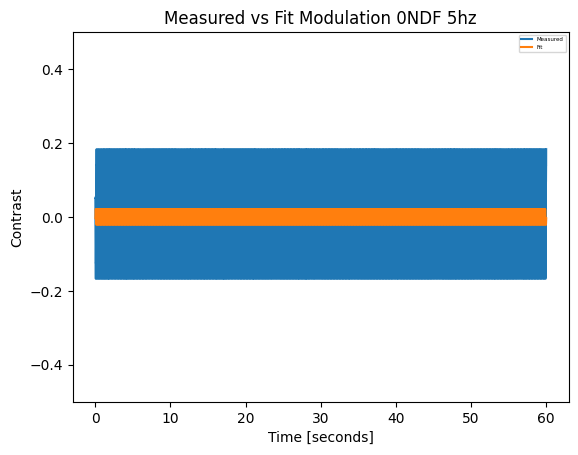

Analyzing chunk 44/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.020541386030793102
Amplitude: 0.02439178114917067


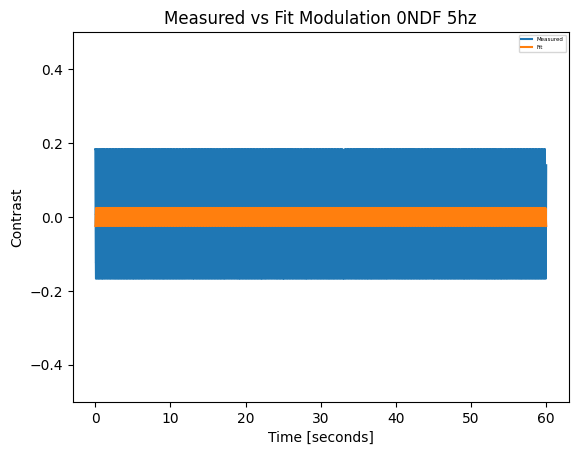

Analyzing chunk 45/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.015697540134177006
Amplitude: 0.021314324007353235


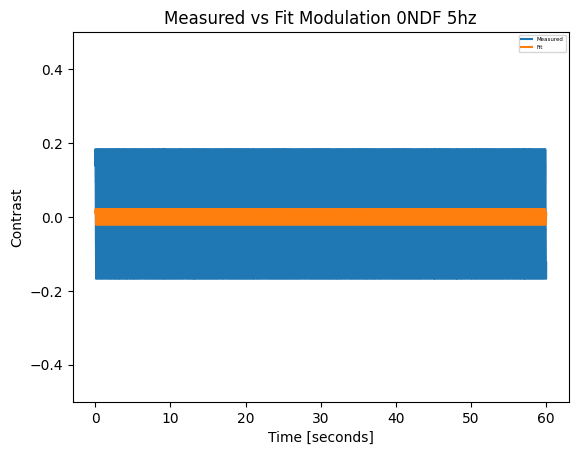

Analyzing chunk 46/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.015290923066914324
Amplitude: 0.021028492524986474


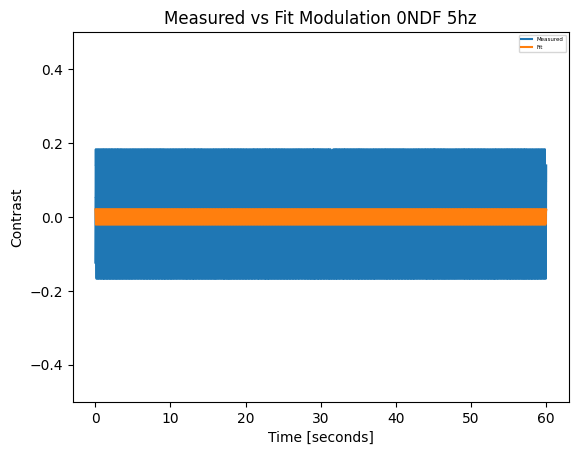

Analyzing chunk 47/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.024823536904610876
Amplitude: 0.026786393945862533


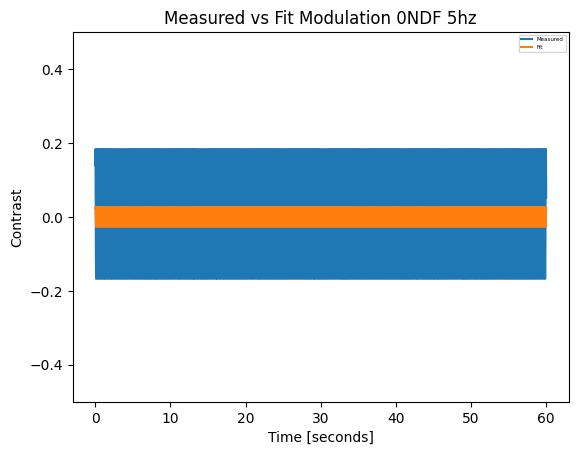

Analyzing chunk 48/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.007201042987640454
Amplitude: 0.014426609183332372


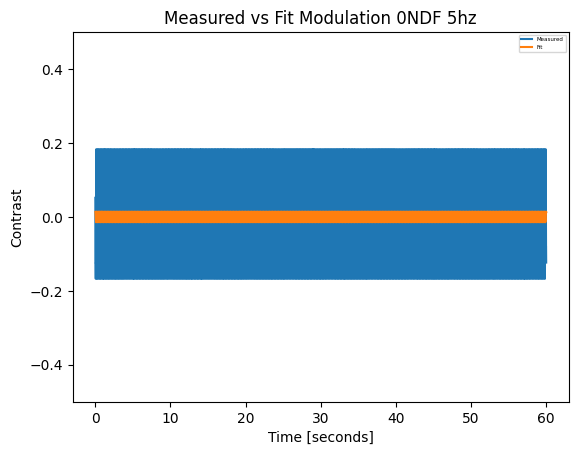

Analyzing chunk 49/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 4.342163262182453e-05
Amplitude: 0.0011194717837035334


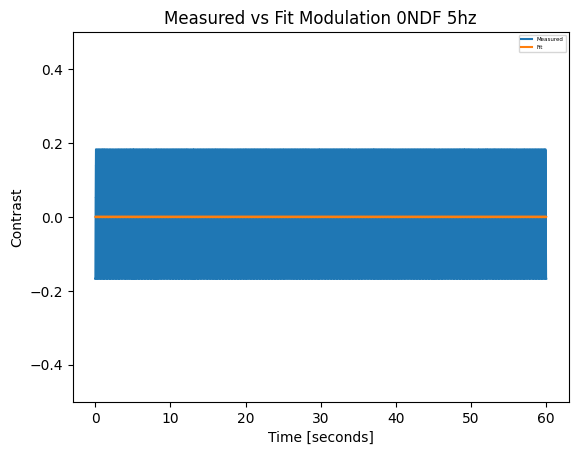

Analyzing chunk 50/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0011064031601792403
Amplitude: 0.005654925947712427


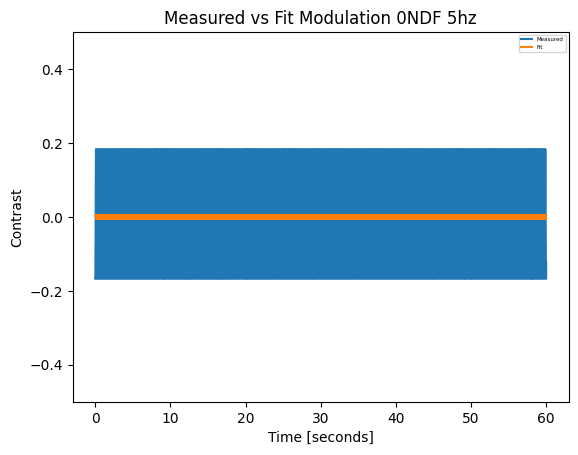

Analyzing chunk 51/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0001494721559415587
Amplitude: 0.0020804345707152515


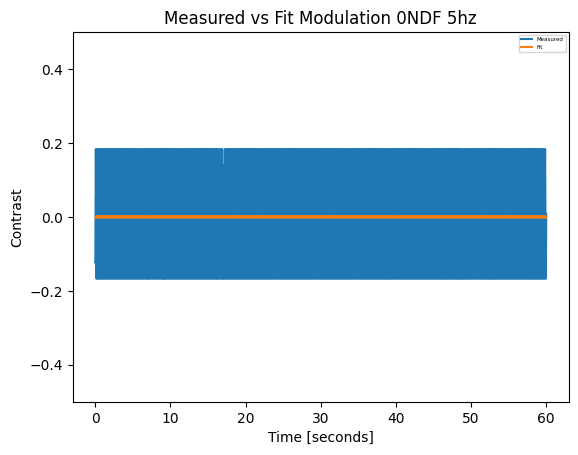

Analyzing chunk 52/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.006606011163529943
Amplitude: 0.013819736572996365


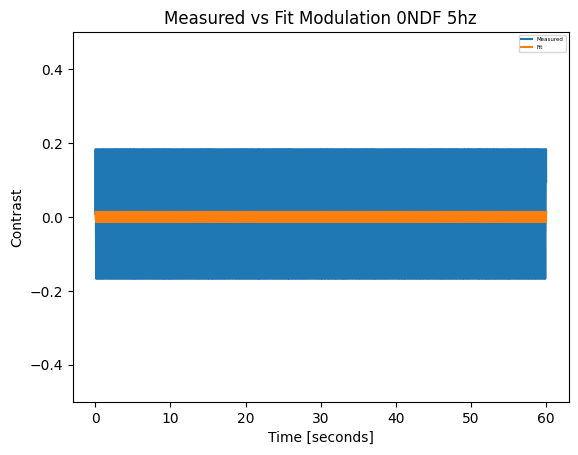

Analyzing chunk 53/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.011116228410390838
Amplitude: 0.017944688211709327


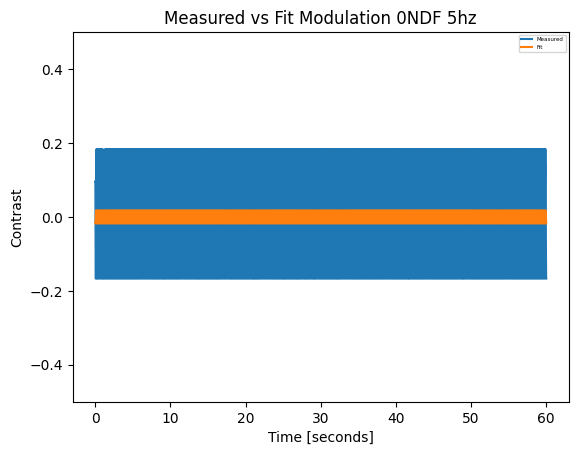

Analyzing chunk 54/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.02162348219370507
Amplitude: 0.024983726532070222


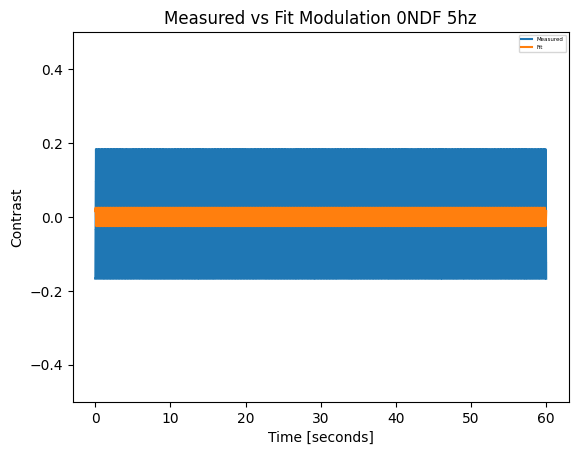

Analyzing chunk 55/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0032076278112606314
Amplitude: 0.009625426985986207


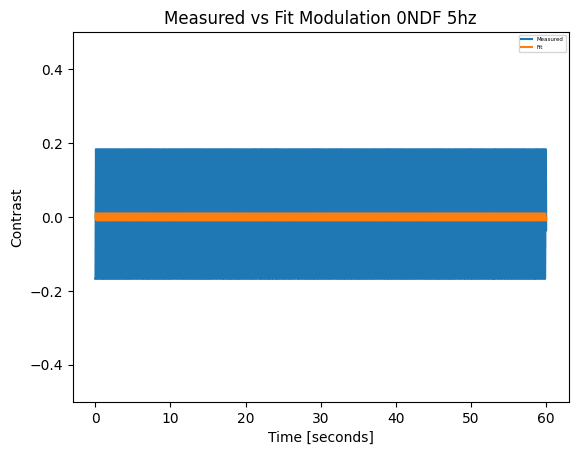

Analyzing chunk 56/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.013293379571633368
Amplitude: 0.019630469210121845


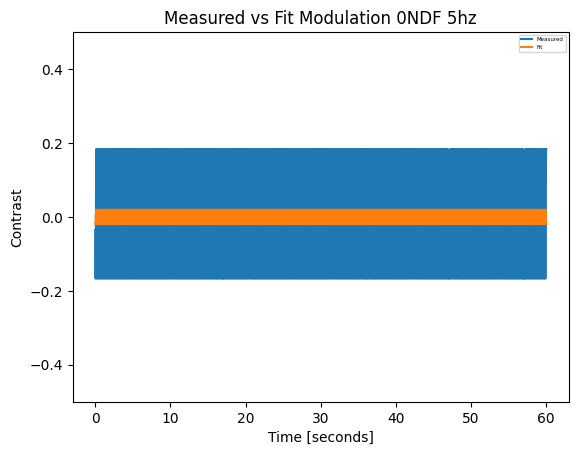

Analyzing chunk 57/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.010448464808295721
Amplitude: 0.01739108255175622


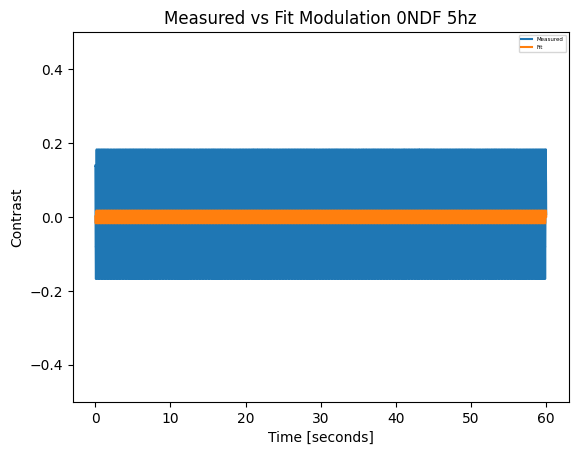

Analyzing chunk 58/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0005875389892681063
Amplitude: 0.0041240861491115876


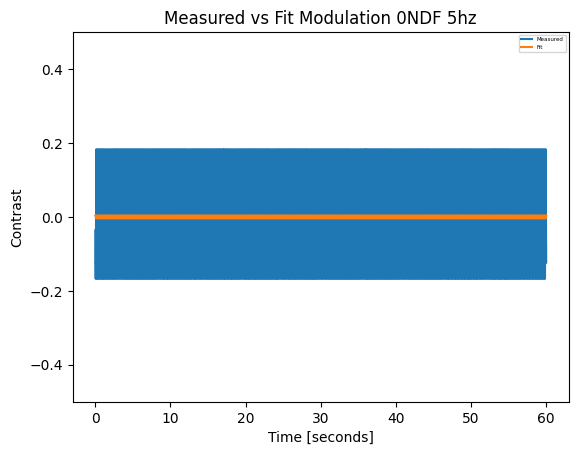

Analyzing chunk 59/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.0018245544461940435
Amplitude: 0.0072697683631739165


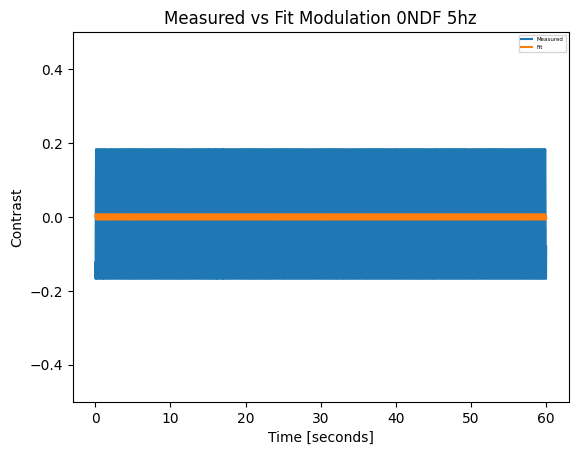

Analyzing chunk 60/61 with size: 60 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.007916526917266398
Amplitude: 0.015133758959428902


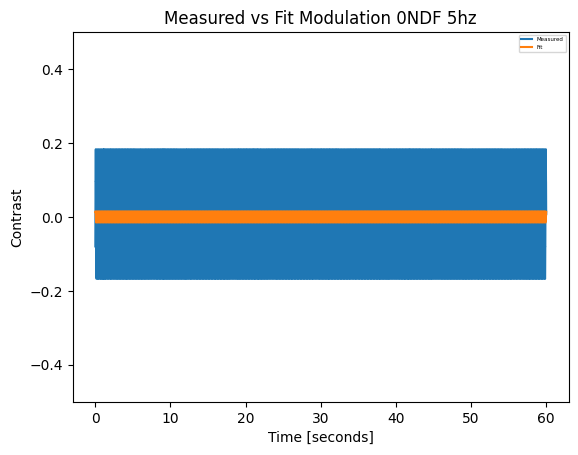

Analyzing chunk 61/61 with size: 18 buffers/seconds...
Estimating fit with: 200FPS
Observed FPS: 200.0
R2: 0.125898920349803
Amplitude: 0.06038015626287688


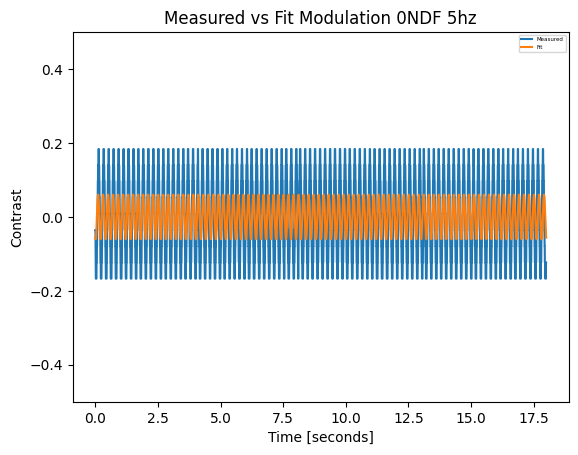

In [13]:
# Examine the world cam data 
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera') # append the path to the camera libraries so we can use their files
import recorder     
import Camera_util

importlib.reload(Camera_util)

# Define the chunksize of time to analyze at a given time 
chunk_seconds: int = 60 # Look at one minute chunks

# Load in the paths to the 1-second buffer files 
buffer_files: list = [os.path.join(world_cam_dir, file) 
                     for file in natsorted(os.listdir(world_cam_dir))]

# Define the chunks
chunks: list = [buffer_files[i:i+chunk_seconds] 
               for i in range(0, len(buffer_files), chunk_seconds)]

# Initialize a container for the fit info for each chunk 
r2_values: list = []
amplitudes: list = []
phases: list = []

# Iterate over the chunks
for chunk_idx, chunk in enumerate(chunks):
    print(f'Analyzing chunk {chunk_idx+1}/{len(chunks)} with size: {len(chunk)} buffers/seconds...')

    # Load in the frames from this chunk
    chunk_frames: np.ndarray = Camera_util.parse_mean_frame_array_buffer(chunk)

    # Initialize an axis to display the fit on 
    fig, ax = plt.subplots(1,1)

    # Fit the modulation for this chunk (without plotting)
    print(f'Estimating fit with: {recorder.CAM_FPS}FPS')
    ret_info: tuple = Camera_util.fit_source_modulation(chunk_frames, str(NDF), frequency, ax=ax, fps_guess=recorder.CAM_FPS, fps_guess_increment=(0,0))

    # Retrieve the amplitude and phase for the fit 
    amplitude, phase = ret_info[:2]

    # Retrieve the R2 from the ret information
    r2: float = ret_info[-1][-1] 

    # Append the info to the running lists of info 
    r2_values.append(r2)
    amplitudes.append(amplitude)
    phases.append(phase)

    # Show the fit
    plt.show()

    # Close the figure
    plt.close(fig)


/var/folders/fb/55l_tk897yjbwpmc6_mm1ylm0000gp/T/ipykernel_26931/196268641.py:30: RuntimeWarning: invalid value encountered in log10
  log_ax.plot(np.log10(measurement))


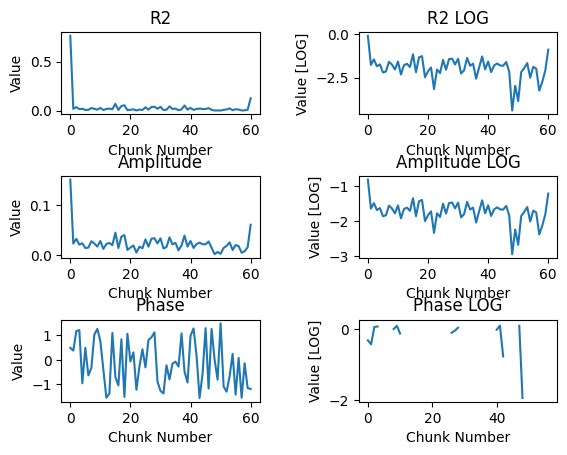

In [31]:
# Plot the R2, amplitudes, and phase by buffer 
# in both log and non-log scale
fig, axes = plt.subplots(3,2)

# Keep track of what axis we are on 
ax_num: int = 0 

# Iterate over the measurements with their associated axes and plot them
for i, (measurement, name, ax_row) in enumerate(zip((r2_values, amplitudes, phases), ('R2', 'Amplitude', 'Phase'), axes)):
    # Retrieve the base 10 ax to plot on 
    # and the log ax 
    ax: plt.Axes = ax_row[0]
    log_ax: axes = ax_row[1]

    # Title the graphs
    ax.set_title(name)
    log_ax.set_title(f'{name} LOG')

    # Label the X axes 
    ax.set_xlabel('Chunk Number')
    log_ax.set_xlabel('Chunk Number')


    # Label the Y axes
    ax.set_ylabel('Value')
    log_ax.set_ylabel('Value [LOG]')

    # Plot the data 
    ax.plot(measurement)
    log_ax.plot(np.log10(measurement))


    # Update the ax num
    ax_num += 2 
    
# Adjust the spacing in the plot
plt.subplots_adjust(wspace=0.5, hspace=1.1)

# Show the plot
plt.show()